In [1]:
#library for understanding music
from music21 import *

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.utils import plot_model
from keras.metrics import *
from keras.regularizers import l2
from keras.utils import np_utils

from sklearn.model_selection import train_test_split



In [2]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Parsing: ",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file, getting a midi file in buffer
    midi = converter.parse(file)
  
    #grouping based on different instruments, sort by instrument
    try:
        instru = instrument.partitionByInstrument(midi)
        notes_to_parse = instru.parts[0].recurse()
    except:
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        #note
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
                
        #chord
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [3]:
#Array Processing
#specify the path
path='data/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")] # make sure we only parse .midi files

#reading each midi file
notes_array = [read_midi(path+i) for i in files] # tuples to array conversion because list cant be hashed



Parsing:  data/01 Divinity - Copy (2).mid
Parsing:  data/01 Divinity - Copy (3).mid
Parsing:  data/01 Divinity - Copy (4).mid
Parsing:  data/01 Divinity - Copy (5).mid
Parsing:  data/01 Divinity - Copy (6).mid
Parsing:  data/01 Divinity - Copy (7).mid
Parsing:  data/01 Divinity - Copy (8).mid
Parsing:  data/01 Divinity - Copy.mid
Parsing:  data/01 Divinity.mid
Parsing:  data/02 Sad Machine - Copy (2).mid
Parsing:  data/02 Sad Machine - Copy (3).mid
Parsing:  data/02 Sad Machine - Copy (4).mid
Parsing:  data/02 Sad Machine - Copy (5).mid
Parsing:  data/02 Sad Machine - Copy (6).mid
Parsing:  data/02 Sad Machine - Copy (7).mid
Parsing:  data/02 Sad Machine - Copy (8).mid
Parsing:  data/02 Sad Machine - Copy.mid
Parsing:  data/02 Sad Machine.mid
Parsing:  data/09 Lionhearted.mid
Parsing:  data/11-2 Technicolor x Divinity.mid
Parsing:  data/Backstreet Boys - As Long As You Love Me.mid
Parsing:  data/Backstreet Boys - I Want It That Way.mid
Parsing:  data/beethoven-symphony9-4-ode-to-joy-pi

# EDA : 

In [4]:
#converting 2D array into 1D array, also exhaustive listing all the notes in the arr 
notes_ = [element for note_ in notes_array for element in note_] 

#No. of unique notes
unique_notes = list(set(notes_))
# number of notes
n_vocab=len(unique_notes)
print(n_vocab)

264


(array([194.,  22.,  15.,   9.,   9.,   6.,   4.,   4.,   0.,   1.]),
 array([1.000e+00, 3.160e+02, 6.310e+02, 9.460e+02, 1.261e+03, 1.576e+03,
        1.891e+03, 2.206e+03, 2.521e+03, 2.836e+03, 3.151e+03]),
 <a list of 10 Patch objects>)

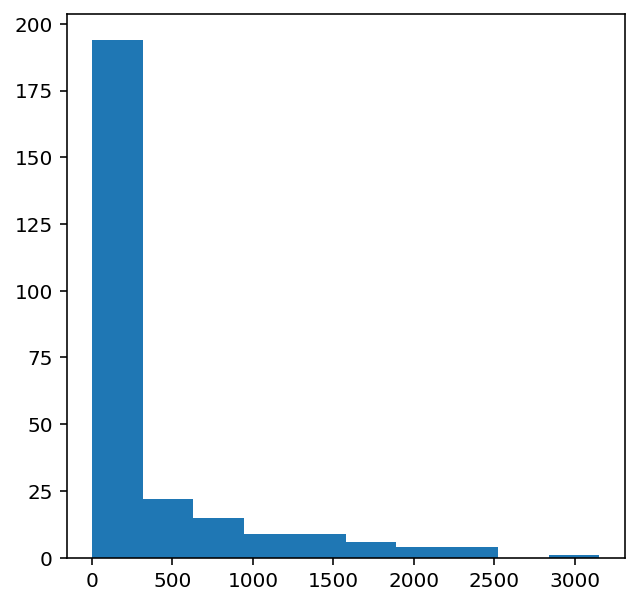

In [5]:
#computing frequency of each note
freq = dict(Counter(notes_)) #using collections here to count, return a dict and we need only the values not the keys

#consider only the frequencies
#return a dict and we need only the values not the keys
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

# if you have time then label the x and y axis and notes(val) and freq

#plot
plt.hist(no)

In [6]:
# tinker with this to get your change 5 to something
frequent_notes = [note_ for note_, count in freq.items() if count>=5]
print(len(frequent_notes))

215


In [7]:
# prepare new musical files which contain only the top frequent notes

new_music=[]

# this adds the most freq notes to a new list new_mewzic
for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)


In [8]:
# feed_notes =[]

# for thing in notes_array:
#     thing = tuple(thing)
#     feed_notes.append(thing)

In [9]:
no_of_timesteps = 128 # aka sequence length
x = []
y = []

for note_ in notes_array:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

n_seq=len(x)   

In [10]:
# numpy.ravel() == numpy.reshape(-1) aka flatten to a 1d array
unique_x = list(set(x.ravel()))
#creating a dict with key as note and value as freq count 
x_note_to_int = dict( (note_, number) for number, note_ in enumerate(unique_x) )

In [11]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [12]:
#preparing input sequences
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [13]:
x_seq = np.reshape(x_seq, (len(x_seq), no_of_timesteps, 1))

# x_seq=x_seq/len(x_seq)

y_seq = np_utils.to_categorical(y_seq,n_vocab)

In [14]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.18)

In [33]:
# x_tr[0]

# import csv

# with open("val1.csv", "w",newline="") as f:
#     writer = csv.writer(f,delimiter=',')
#     writer.writerows(x_tr[0])

In [15]:
print(x_tr.shape)
print(y_tr.shape)

(67950, 128, 1)
(67950, 264)


In [16]:
#make sure i am using 2080 and not cpu
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# B-LSTM

In [17]:
# K.clear_session()

model = Sequential()
#input layer
# model.add(Embedding(len(unique_x), 128, input_length=no_of_timesteps ,trainable=True)) 
model.add(LSTM(128, input_shape=(no_of_timesteps,x_tr.shape[2]), return_sequences=True))

#layer 1
model.add(Bidirectional(LSTM(128,return_sequences=True)))

#layer 2
model.add(Bidirectional(LSTM(256,return_sequences=True,kernel_regularizer=l2(0.01))))

#layer 3
model.add(Bidirectional(LSTM(256)))

#layer 4
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))

#layer 5
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))

#layer 6
model.add(Dense(n_vocab,activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


#try to add attention to this model

# CNN 

In [18]:
# model = Sequential()
    
# #embedding layer
# model.add(Embedding(len(unique_x), 100, input_length=no_of_timesteps ,trainable=True)) 

# model.add(Conv1D(64,3, padding='causal',activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))
    
# model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))

# model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
# model.add(Dropout(0.2))
# model.add(MaxPool1D(2))
          
# #model.add(Conv1D(256,5,activation='relu'))    
# model.add(GlobalMaxPool1D())
    
# model.add(Dense(256, activation='relu'))
# model.add(Dense(len(unique_y), activation='softmax'))
    
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [19]:
# mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [20]:
#this is a custom callback lol :

In [26]:
model.fit(np.array(x_tr),np.array(y_tr),epochs=5,validation_data=(np.array(x_val),np.array(y_val)),verbose=1)

Epoch 1/5
2124/2124 [==============================] - 130s 61ms/step - loss: 0.3775 - accuracy: 0.9076 - val_loss: 0.6746 - val_accuracy: 0.8705
Epoch 2/5
2124/2124 [==============================] - 129s 61ms/step - loss: 0.3668 - accuracy: 0.9107 - val_loss: 0.7009 - val_accuracy: 0.8649
Epoch 3/5
2124/2124 [==============================] - 131s 62ms/step - loss: 0.3857 - accuracy: 0.9067 - val_loss: 0.6853 - val_accuracy: 0.8690
Epoch 4/5
2124/2124 [==============================] - 129s 61ms/step - loss: 0.3587 - accuracy: 0.9130 - val_loss: 0.7176 - val_accuracy: 0.8650
Epoch 5/5
2124/2124 [==============================] - 130s 61ms/step - loss: 0.3502 - accuracy: 0.9152 - val_loss: 0.7191 - val_accuracy: 0.8673


In [27]:
# save entire model to HDF5 
model.save("mewzic_model.h5")

In [18]:
from keras.models import load_model
model = load_model('mewzic_model.h5')

In [21]:
# import pickle
# pickle.dump(model, open('p_model','wb'))

TypeError: cannot pickle '_thread.RLock' object

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 128)          66560     
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 512)          1050624   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

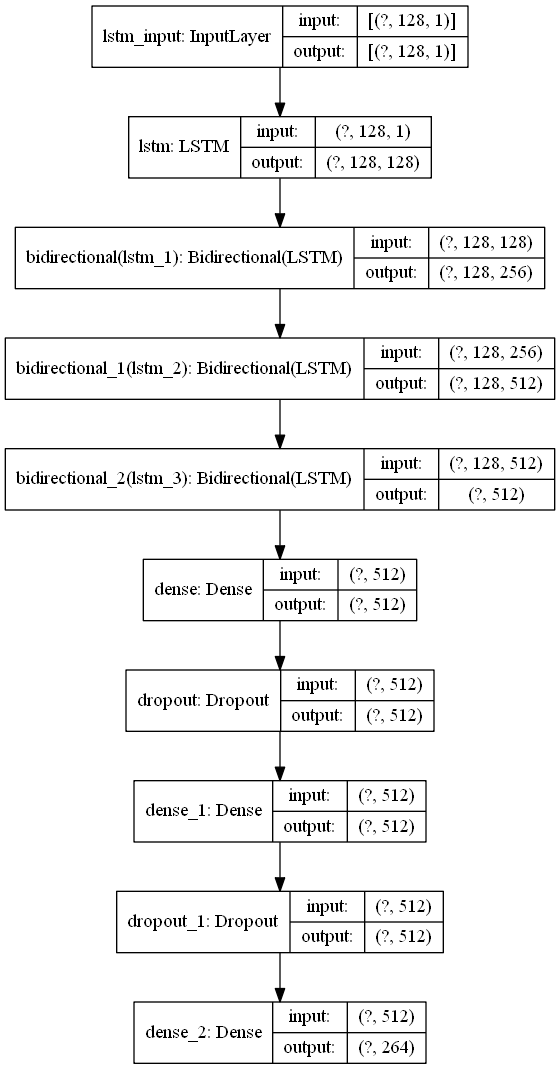

In [30]:
dot_img_file = 'model_summary.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

# method 1

In [31]:
# # fix this so that the model is more seq
# ind = np.random.randint(0,len(x_val)-1)

# #may be use x_tr instead?
# random_music = x_tr[ind]

# predictions=[]
# for i in range(64): # this changes the length of the music output
#     random_music = random_music.reshape(1,no_of_timesteps)
    
#     prob  = model.predict(random_music)[0] #[0] returns the first element of whatever model.predict
#     y_pred= np.argmax(prob,axis=0) # getting the index
#     predictions.append(y_pred)

#     random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
#     random_music = random_music[1:]
    
# print(predictions)

In [32]:
# #integers back into the notes
# x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
# predicted_notes = [x_int_to_note[i] for i in predictions] # feed this to conver to midi fx

In [33]:
# def convert_to_midi(prediction_output):
   
#     offset = 0
#     output_notes = []

#     # create note and chord objects based on the values generated by the model
#     for pattern in prediction_output:
        
#         # pattern is a chord
#         if ('.' in pattern) or pattern.isdigit():
#             notes_in_chord = pattern.split('.')
#             notes = []
#             for current_note in notes_in_chord:
                
#                 cn=int(current_note)
#                 new_note = note.Note(cn)
#                 new_note.storedInstrument = instrument.Piano()
#                 notes.append(new_note)
                
#             new_chord = chord.Chord(notes)
#             new_chord.offset = offset
#             output_notes.append(new_chord)
            
#         # pattern is a note
#         else:
            
#             new_note = note.Note(pattern)
#             new_note.offset = offset
#             new_note.storedInstrument = instrument.Piano()
#             output_notes.append(new_note)

#         # increase offset each iteration so that notes do not stack
#         offset += 0.5
#     midi_stream = stream.Stream(output_notes)
#     midi_stream.write('midi', fp='output/mewzic.mid')


# method 2

In [34]:
#unique_x is pitch names
start=np.random.randint(0, len(x_tr)-1)

x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))

seq=x_tr[start]
predictions=[]

for i in range(64):
    pred_ip=np.reshape(seq,(1,len(seq),1))
    pred_ip=pred_ip/len(pred_ip)
    
    prediction=model.predict(pred_ip,verbose=0)
    
    index=np.argmax(prediction)
    result=x_int_to_note[index]
    predictions.append(result)
    
#     seq.append(index)
    seq = np.append(seq,index)
    seq=seq[1:len(seq)]
    
print(predictions)



['A7', '0.1', 'A7', '0.1', 'G7', 'A7', '0.1', '8.11.3', 'A7', '0.1', 'G2', '8.10.11', 'C6', 'G2', '8.10.11', 'G2', '8.10.11', 'G2', '8.10.11', 'G2', '8.10.11', 'G2', '8.10.11', 'G2', '8.10.11', 'G2', '8.10.11', '1.2', '0.2.5', '4.8.11', '1.2', 'C6', 'D6', '1.2', 'C6', 'D6', '1.2', 'C6', 'D6', '1.2', '0.4.7', '0.1', 'C6', 'D6', 'C6', 'C#6', 'B6', 'C#6', 'B6', 'C#6', 'B6', 'C#6', 'B6', 'G7', 'C#6', 'B6', '8.11.3', 'C#6', 'B6', 'C#6', 'B6', 'C6', 'C#6', 'B6']


In [35]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in predictions:

    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:

            cn = int(current_note)
            new_note = note.Note(cn)
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)

        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)

    # pattern is a note
    else:

        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.54

In [36]:
# convert_to_midi(predicted_notes)

In [37]:
midi_stream=stream.Stream(output_notes)
midi_stream.write('midi', fp='output/mewzic.mid')

'output/mewzic.mid'